# Dynamic Programming (DP)

Ref: 
1.  Book: Reinforcement Learning: An Introduction V2 (http://incompleteideas.net/book/bookdraft2017nov5.pdf#_blank)
2. David Silver Lectures (http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)

Dynamic Programming or (DP) is a method for solving complex problems by breaking them down into subproblems, solve the subproblems, and combine solutions to the subproblems to solve the overall problem.

Dynamic Programming is a very general solution method for problems which have two properties:
* Optimal substructure
    * Principle of optimality applies
    * Optimal solution can be decomposed into subproblems
* Overlapping subproblems
    * Subproblems recur many times
    * Solutions can be cached and reused
* Markov decision processes satisfy both properties
    * Bellman equation gives recursive decomposition
    * Value function stores and reuses solutions

What gives us the overlapping subproblems property in MDPs is the value function. It is like a cache of the good information we figured out about the MDP.

* Dynamic programming assumes full knowledge of the MDP
* It is used for planning in an MDP
* For prediction:
    * Input: MDP, where M = (S, A, P, R, 𝛾) and policy 𝜋
    *    or: MRP where M = (S, P, R, 𝛾)
    * Output: value function, V𝜋
* Or For control:
    * Input: MDP, M = (S, A, P, R, 𝛾)
    * Output: optimal value function V*
    *    and: optimal polity 𝜋*

DP may not be practical for very large problems, but compared with other methods for solving MDPs, DP methods are actually quite efficient.

Dynamic programming is used to solve many other problems, e.g.
* Scheduling algorithms
* String algorithms (e.g, sequence alignment)
* Graph algorithms (e.g., shortest path algorithms)
* Bioinformatics (e.g., lattic models)

In this lab, we will focus on three DP algorithms - (1) Policy Evaluation (2) Policy Iteration and Improvement and (3) Value Iteration.

Policy evaluation refers to the (typically) iterative computation of the value functions for a given policy. Policy improvement refers to the computation of an improved policy given the value function for that policy. Putting these two computations together, we obtain policy iteration and value iteration, the two most popular DP methods. Either of these can be used to
reliably compute optimal policies and value functions for finite MDPs given complete knowledge of the MDP.

## Policy Evaluation 

In policy evaluation, we are given an MDP (state-value function) and an arbitrary policy 𝜋. We will evaluate the given policy through iterative application of **Bellman expectation equation**, and later use the Bellman optimality equation to do control.

We are going to start off with an initial value function, e.g. zero for all states. We are going to implement one step lookahead using Bellman expectation equation to figure out a new value function, iterate this process many times for all states, and at the end we will end up with the true value function for the given policy.

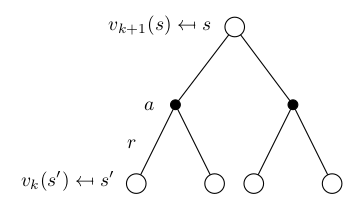

To do this we are going to use synchronous backups, which means at each iteration k+1, we’ll consider all state s ∈ S, update Vk+1(s) which is the current iteration from Vk(s′) where s′ is a successor state of s.

Formally, we are gonna start with our previous value function, which is initially zeros, we are going to apply iterative update to every single state in this value function to produce a complete new value function for all states and carry on with this process. This is called synchronous evaluation.


In DP, we will turn Bellman expectation equation into iterative update,

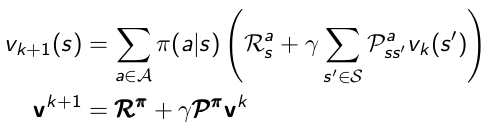

We will define the value function of the current iteration by plugging in the previous iteration values in the leafs and then iterate this process. This is guaranteed to **converge** on the true value function for the given policy.

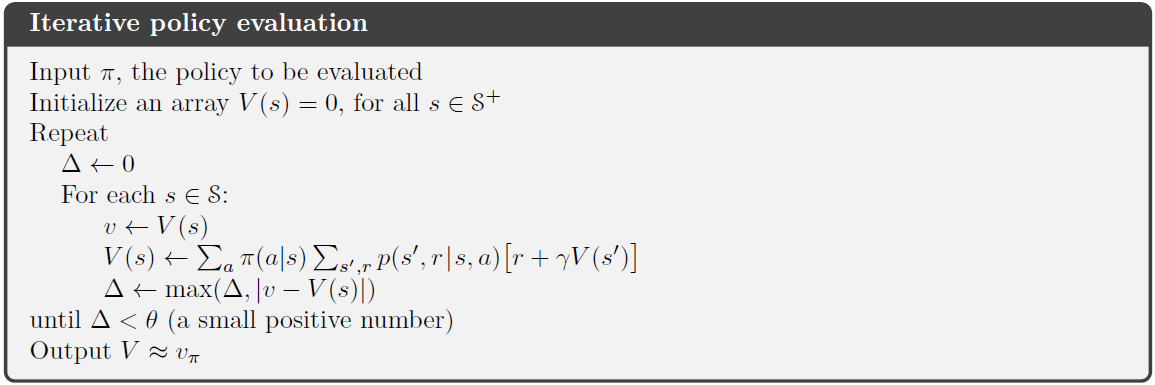

### Evaluating a random policy in a small Gridworld

Consider a 4x4 grid as shown below,

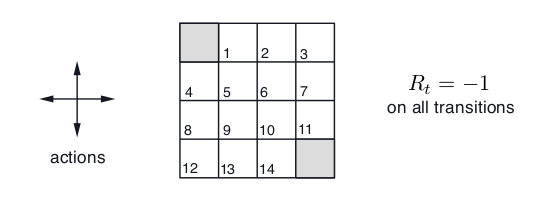

The nonterminal states are S = {1, 2, …, 14}. There are four actions possible in each state, A = {up, down, right, left}, which deterministically cause the corresponding state transitions, except that actions that would take the agent off the grid in fact leave the state unchanged. The reward is -1 on all transitions until the terminal state is reached. The terminal state is shaded in the figure (although it is shown in two places, it iss formally one state). The agent follows uniform random policy,




Here is the convergence of iterative policy evaluation on the left column on a small gridworld,

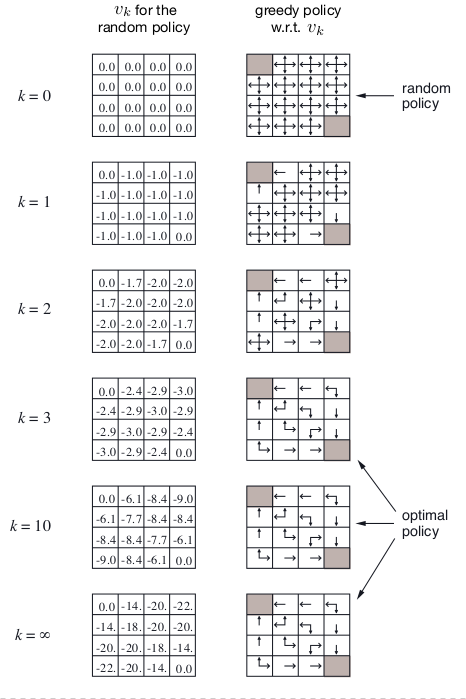

In [1]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.

    For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

    x is your position and T are the two terminal states.

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            P[s] = {a : [] for a in range(nA)}

            is_done = lambda s: s == 0 or s == (nS - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)
        
    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip() 
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

In [4]:
import numpy as np 
import pprint
import gym.spaces
#from gridworld import GridworldEnv

pp = pprint.PrettyPrinter(indent=2)

env = GridworldEnv()

In [5]:
def policy_eval(policy, env, discount_factor=1.0, epsilon=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)

    while True:
        
        #old value function
        V_old = np.zeros(env.nS)
        #stopping condition
        delta = 0

        #loop over state space
        for s in range(env.nS):

            #To accumelate bellman expectation eqn
            Q = 0
            #get probability distribution over actions
            action_probs = policy[s]

            #loop over possible actions
            for a in range(env.nA):

                #get transitions
                [(prob, next_state, reward, done)] = env.P[s][a]
                #apply bellman expectatoin eqn
                Q += action_probs[a] * (reward + discount_factor * V[next_state])

            #get the biggest difference over state space
            delta = max(delta, abs(Q - V[s]))

            #update state-value
            V_old[s] = Q

        #the new value function
        V = V_old

        #if true value function
        if(delta < epsilon):
            break

    return np.array(V)

In [6]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
print(random_policy)
v = policy_eval(random_policy, env)

expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

print(v)
print(expected_v)


[[ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]]
[  0.         -13.99989315 -19.99984167 -21.99982282 -13.99989315
 -17.99986052 -19.99984273 -19.99984167 -19.99984167 -19.99984273
 -17.99986052 -13.99989315 -21.99982282 -19.99984167 -13.99989315   0.        ]
[  0 -14 -20 -22 -14 -18 -20 -20 -20 -20 -18 -14 -22 -20 -14   0]


## Policy Iteration and Improvement

Our reason for computing the value function for a policy is to help find better policies. Suppose we have determined the value function V𝜋 for an arbitrary deterministic policy 𝜋. For some state s we would like to know whether or not we should change the policy to deterministically choose an action a ≠ 𝜋(s).

We know how good it is to follow the current policy from s, that is V𝜋(s), but would it be better or worse to change to the new policy? One way to answer this question is to consider selecting **a** and **s** and thereafter following the existing policy, 𝜋.

The value of this way of behaving is,

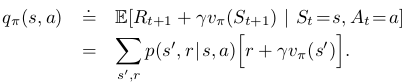


The key criterion is whether this is greater than or less than V𝜋(s). If it is greater, that is if it is better to select a once in s and thereafter follow 𝜋 than it would be to follow 𝜋 all the time, then one would expect it to be better still to select a every time s is encountered, and the new policy would be in fact a better one overall.

So formally, given a policy 𝜋, (1) we are going to evaluate it, i.e. we are going to figure out a value function for that policy like in the left column in Fig. 1,

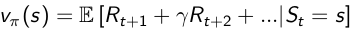

and then (2) we improve the policy by acting greedily with respect to V𝜋 like we did on the right column, where we look ahead in each direction and pick the best action, that is what it means to act greedily,

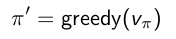

As show in the figure below, we start off with some arbitrary value function and some policy. We’re gonna do policy evaluation on the up arrows and policy improvement on the down arrows,

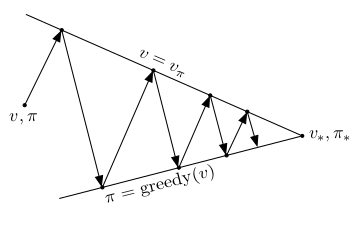

We evaluate the initial policy on the first arrow. Once we evaluated that policy, we act greedily with respect to the value function on that policy to give us a new policy. Once we got that new policy, we evaluate it on the third arc, that gives us a new value function. Once we have that new value function, we act greedily with respect to it to get a new policy and so forth.

In a small gridworld, improved policy was optimal after the third iteration. In general, we need more iterations of improvement/evaluation. In interesting problems, we can go around these two steps of improvement and evaluation again and again, and this process of policy iteration always converges to the optimal policy 𝜋*.

The idea behind the proof of the policy improvement theorem is easy to understand,

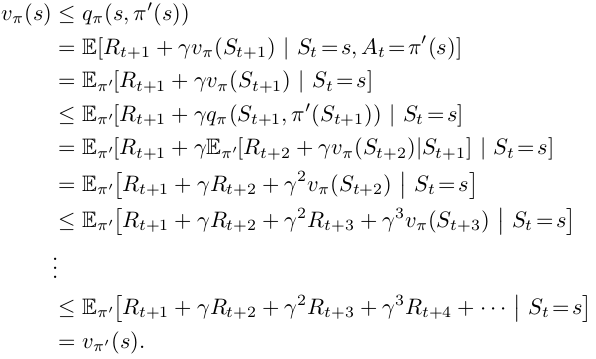

As we act greedily, we pick the best action in state s, which is the reward for that action combined with the discounted value of successor state on policy 𝜋. The value of that action is less than or equal to the same action value if we replaced the value of the successor state on policy 𝜋 with the greedy action value in the successor state. Apply this idea to all states, and eventually we will end up with a new value function on the greedy policy 𝜋′ which is better than the previous policy 𝜋.

If improvement stops, that means that the greedy action value is the value of the current state on the current policy,

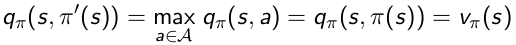



Then Bellman optimality equation has been satisfied,

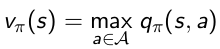

therefore V𝜋(s) = V*(s) for all s ∈ S, so 𝜋 is an optimal policy.

Here is the code of policy iteration on the gridworld,

In [7]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
       
    """
    def one_step_lookahead(s, value_fn):

        actions = np.zeros(env.nA)

        for a in range(env.nA):

            [(prob, next_state, reward, done)] = env.P[s][a]
            actions[a] = prob * (reward + discount_factor * value_fn[next_state])
            
        return actions

    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    actions_values = np.zeros(env.nA)

    while True:

        #evaluate the current policy
        value_fn = policy_eval_fn(policy, env)
       
        policy_stable = True

        #loop over state space
        for s in range(env.nS):


            #perform one step lookahead
            actions_values = one_step_lookahead(s, value_fn)
            
            #maximize over possible actions 
            best_action = np.argmax(actions_values)

            #best action on current policy
            chosen_action = np.argmax(policy[s])

            #if Bellman optimality equation not satisifed
            if(best_action != chosen_action):
                policy_stable = False

            #the new policy after acting greedily w.r.t value function
            policy[s] = np.eye(env.nA)[best_action]

        #if Bellman optimality eqn is satisfied
        if(policy_stable):
            return policy, value_fn

In [8]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



## Modified or Improved Policy Iteration

In girdworld, if we did just few iteration of Bellman expectation equation, that was really enough for this problem to come up with a better policy. We did not need to evaluate this thing perfectly and act greedily with respect to it. In fact all additional iterations were a waste of time. Can we truncate our evaluation process and use approximate policy evaluation rather than exact policy evaluation?.

Does policy evaluation need to converge to V𝜋, or we need introduce a stopping condition. The basic idea is to stop when we get close enough to the value function we care about. So we can say look at how much your Bellman updates change in the value function, when there is a change in the value function by some tiny amount ε, then you can just stop. This is called ε-convergence of value function.

But even this will probably be a waste of time too. We can do some thing more naive by stopping after k-iterations of iterative policy evaluation, e.g. in small gridworld the third iteration was sufficient to achieve optimal policy.

## Value Iteration

Any optimal policy can be subdivided into two components; an optimal first action, followed by an optimal policy from successor state **s′**. If our first action is optimal and after that we follow an optimal policy from wherever we end up, then we can say that the overall behavior is optimal.

The theorem of principle of optimality says,

**A policy 𝜋(a|s) achieves the optimal value from state s, i.e. V𝜋(s) = V*(s), if and only if, for any state s′ reachable from s, 𝜋 achieves the optimal value from state s′, V𝜋(s′) = V*(s′)**.

So we can break down the description of what it means to have an optimal policy in terms of finding the optimal policy from all states we can end up in. Once we do that, then we just need to do this one step lookahead and figure out what is the best first action we could have taken is and we’re done. This is the principle of optimality applied to policies.

If we know the solution to the subproblem V*(s′), i.e. the optimal value function from s′, then V*(s) can be found by one step lookahead,

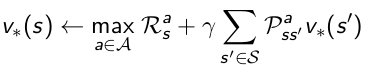

In value iteration, we iteratively apply Bellman optimality equation to get the optimal value function. At each iteration k+1 update Vk+1(s) from Vk(s′) for all state s ∈ S. Unlike policy iteration, there is no explicit policy, and intermediate value functions may not correspond to any policy.The convergence rate is independent of where we start off.

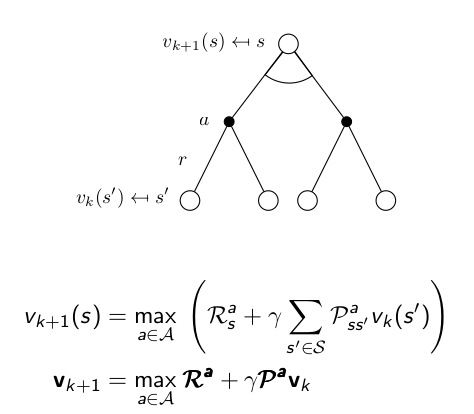

At every iteration, each state gets a turn to be the root. We start off by our old value function Vk(s′) and we put it in the leafs. We are taking Bellman optimality equation and we are turning it into an iterative update.

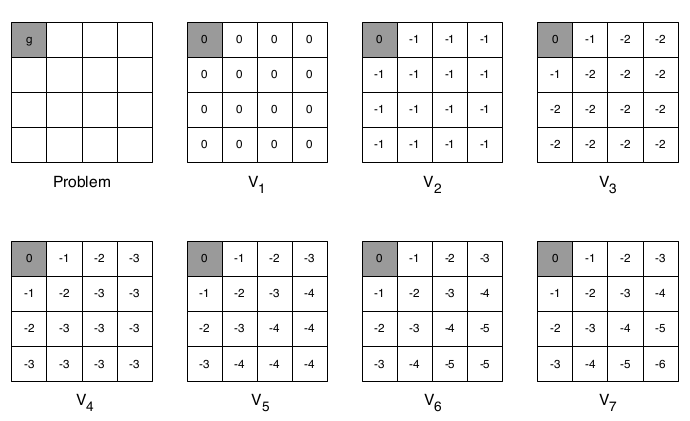

In the gridworld, the intuition is, we start with final rewards and work backwards. Initially, we start off with zero value function. In the second iteration, after applying Bellman optimality equation, we end up with -1 for each state, which is the result of maximizing over possible actions in a given state. Notice that the -1 resulted from the reward add to the discounted value of successor state, which is was zeros at V1, so we end up with -1 for the first iteration.

Here is the code for value iteration in a gridworld,

In [9]:
def value_iteration(env, epsilon=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    def one_step_lookahead(V, a, s):

        [(prob, next_state, reward, done)] = env.P[s][a]
        v = prob * (reward + discount_factor * V[next_state])

        return v
    
    #start with inital value function and intial policy
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])

    #while not the optimal policy
    while True:

        delta = 0

        #loop over state space
        for s in range(env.nS):

            actions_values = np.zeros(env.nA)

            #loop over possible actions
            for a in range(env.nA):

                #apply bellman eqn to get actions values
                actions_values[a] = one_step_lookahead(V, a, s)

            #pick the best action
            best_action_value = max(actions_values)

            #get the biggest difference between best action value and our old value function
            delta = max(delta, abs(best_action_value - V[s]))

            #apply bellman optimality eqn
            V[s] = best_action_value

            #to update the policy
            best_action = np.argmax(actions_values)

            #update the policy
            policy[s] = np.eye(env.nA)[best_action]


        #if optimal value function
        if(delta < epsilon):
            break
    
    return policy, V


In [10]:
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



** To Summarize:**

* Prediction:
    * Apply Bellman Expectation Equation
    * Iterative; Policy Evaluation
* Control:
    * Bellman Expectation Equation + Greedy Policy Improvement
    * Policy Iteration
* Control:
    * Bellman Optimality Equation
    * Value Iteration
    
**Note: Algorithms are based on state-value function V𝜋(S) or V*(S); complexity is O(mn^2) per iteration, for m actions and n states.

In prediction problem, we are trying to figure out how much reward we get from some given policy. To figure that out we use the Bellman expectation equation and turn it into iterative update. So we end up with iterative policy evaluation.

In control, there are two different ways; the first was to use Bellman expectation equation to evaluate our policy iteratively and alternate this process of policy evaluation to policy improvement, and that gave us the policy iteration algorithm. The second way was to use the Bellman optimality equation and turn it into iterative update to end up with the value iteration algorithm.

# Asynchronous Dynamic Programming

DP methods described so far used synchronous backups i.e., all states are backed up in parallel.

Asynchronous DP backs up states individually, in any order, for each selected state, apply the appropriate backup, makes significant reduction in the computation and also will guarantee the **Convergence** if all states continue to be selected.

Three key ideas for asynchronous DP: (1) in-place DP (2) prioritized sweeping (3) real-time DP.
